# Generative Model Benchmarking

The goal here is to use the [data programing paradigm](https://arxiv.org/abs/1605.07723) to probabilistically label our training dataset for the disease associates gene realtionship. The label functions have already been generated and now it is time to train the generative model. This model captures important features such as agreements and disagreements between label functions; furthermore, this model can capture the dependency structure between label functions (i.e. correlations between label functions). More information can be found in this [blog post](https://hazyresearch.github.io/snorkel/blog/structure_learning.html) or in this [paper](https://arxiv.org/abs/1703.00854). The underlying hypothesis here is: **Incorporating multiple weak sources improves prediction performance compared towards the normal distant supervision approach**.

## Set up The Environment

The few blocks below sets up our python environment to perform the experiment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import LabelAnnotator
from snorkel.learning.structure import DependencySelector
from snorkel.models import candidate_subclass

from metal.analysis import confusion_matrix
from metal.label_model import LabelModel
from metal.utils import convert_labels
from metal.contrib.visualization.analysis import(
    plot_predictions_histogram, 
)

from utils.label_functions.disease_gene_lf_multitask import DG_LFS

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.label_matrix_helper import (
    get_auc_significant_stats, 
    get_overlap_matrix, 
    get_conflict_matrix, 
    make_cids_query,
    label_candidates
)
from utils.notebook_utils.train_model_helper import train_generative_model
from utils.notebook_utils.plot_helper import (
    plot_label_matrix_heatmap, 
    plot_curve, 
    plot_generative_model_weights, 
)

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
quick_load = True

## Load the data for Generative Model Experiments

In [6]:
spreadsheet_names = {
    'train': '../../sentence_labels_train.xlsx',
    'dev': '../../sentence_labels_dev.xlsx',
    'test': '../../sentence_labels_test.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of train set: 50000
Size of dev set: 210
Size of test set: 140


In [8]:
label_functions = (
    list(DG_LFS["DaG"].values())
) 

if quick_load:
    label_matricies = pickle.load(open("label_matricies.pkl", "rb"))
else:
    #labeler = LabelAnnotator(lfs=label_functions)
    label_matricies = {
        key:label_candidates(
            session,
            candidate_dfs[key]['candidate_id'],
            label_functions,
            num_threads=10, 
            batch_size=candidate_dfs[key]['candidate_id'].shape[0]
        )
        for key in candidate_dfs
    }

In [9]:
lf_names = list(DG_LFS["DaG"].keys())

## Visualize Label Functions

Before training the generative model, here are some visualizations for the given label functions. These visualizations are helpful in determining the efficacy of each label functions as well as observing the overlaps and conflicts between each function.

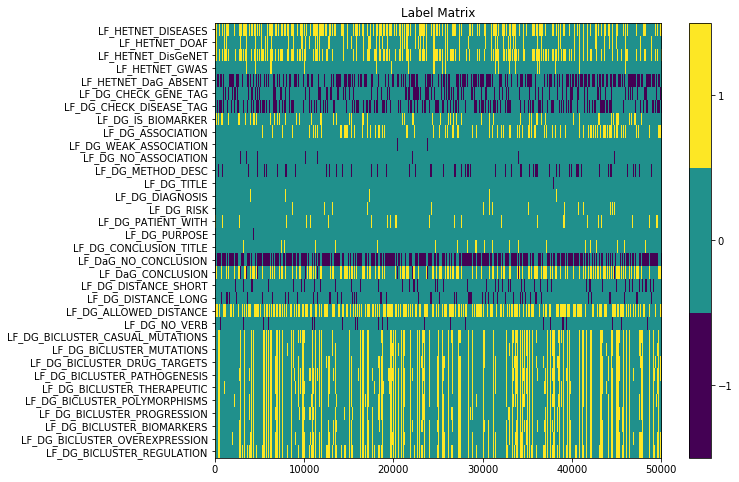

In [10]:
plt.rcParams.update({'font.size': 10})
plot_label_matrix_heatmap(label_matricies['train'].T, 
                          yaxis_tick_labels=lf_names, 
                          figsize=(10,8), font_size=10)

Looking at the heatmap above, this is a decent distribution of labels. Some of the label functions are outputting a lot of labels (distant supervision ones) and some are very sparse in their output. Nevertheless, nothing shocking scream out here in terms of label function performance. 

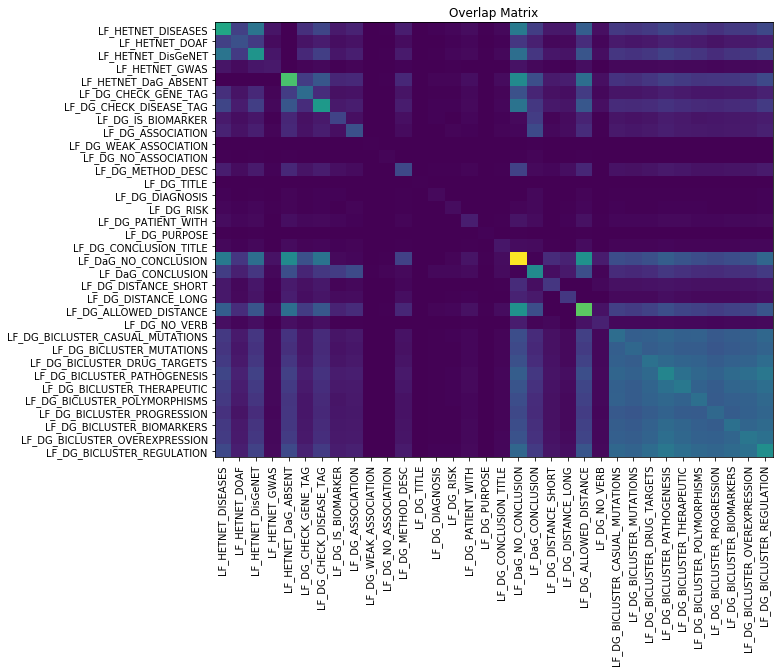

In [11]:
plot_label_matrix_heatmap(get_overlap_matrix(label_matricies['train'], normalize=True), 
                          yaxis_tick_labels=lf_names, xaxis_tick_labels=lf_names,
                          figsize=(10,8), colorbar=False, plot_title="Overlap Matrix")

The overlap matrix above shows how two label functions overlap with each other. The brighter the color the more overlaps a label function has with another label function. Ignoring the diagonals, there isn't much overlap between functions as expected.

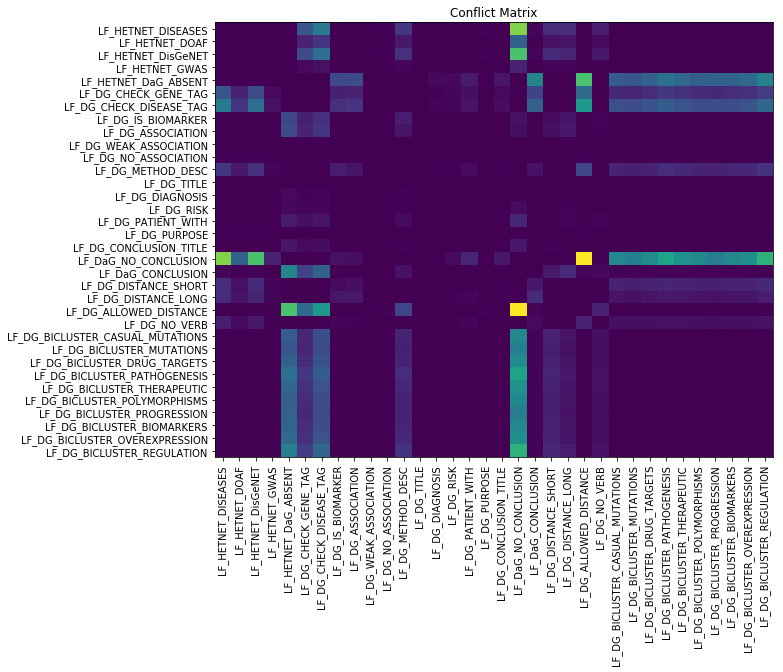

In [12]:
plot_label_matrix_heatmap(get_conflict_matrix(label_matricies['train'], normalize=True), 
                          yaxis_tick_labels=lf_names, xaxis_tick_labels=lf_names,
                          figsize=(10,8), colorbar=False, plot_title="Conflict Matrix")

The conflict matrix above shows how often label functions conflict with each other. The brighter the color the more conflict a label function has with another function. Ignoring the diagonals, there isn't many conflicts between functions except for the LF_DG_NO_CONCLUSION and LF_DG_ALLOWED_DISTANCE. Possible reasons for lack of conflicts could be lack of coverage a few functions have, which is shown in the cell below.

# Train the Generative Model

After visualizing the label functions and their associated properties, now it is time to work on the generative model. AS with common machine learning pipelines, the first step is to find the best hyperparameters for this model. Using the grid search algorithm, the follow parameters were optimized: amount of burnin, strength of regularization, number of epochs to run the model.

## Set the hyperparameter grid search

In [13]:
regularization_grid = pd.np.round(pd.np.linspace(0.1, 6, num=25), 3)

## What are the best hyperparameters for the conditionally independent model?

In [14]:
L = convert_labels(label_matricies['train'].toarray(), 'plusminus', 'categorical')
L_dev = convert_labels(label_matricies['dev'].toarray(), 'plusminus', 'categorical')
L_test = convert_labels(label_matricies['test'].toarray(), 'plusminus', 'categorical')

validation_data = list(zip([L[:,:7], L[:, :24], L], [L_dev[:,:7], L_dev[:, :24], L_dev]))
test_data = list(zip([L[:,:7], L[:, :24], L], [L_test[:,:7], L_test[:, :24], L_test]))
model_labels = ["Distant Supervision (DS)", "DS+User Defined Rules", "All"]

In [15]:
model_grid_search = {}
for model_data, model_label in zip(validation_data, model_labels):
    
    label_model = LabelModel(k=2, seed=100)
    grid_results = {}
    for param in regularization_grid:
        label_model.train_model(model_data[0], n_epochs=1000, verbose=False, lr=0.01, l2=param)
        grid_results[str(param)] = label_model.predict_proba(model_data[1])[:,0]
        
    model_grid_search[model_label] = pd.DataFrame.from_dict(grid_results)

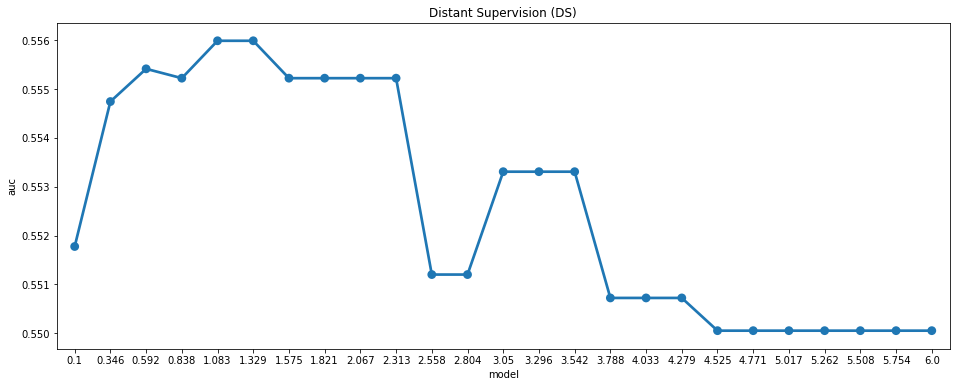

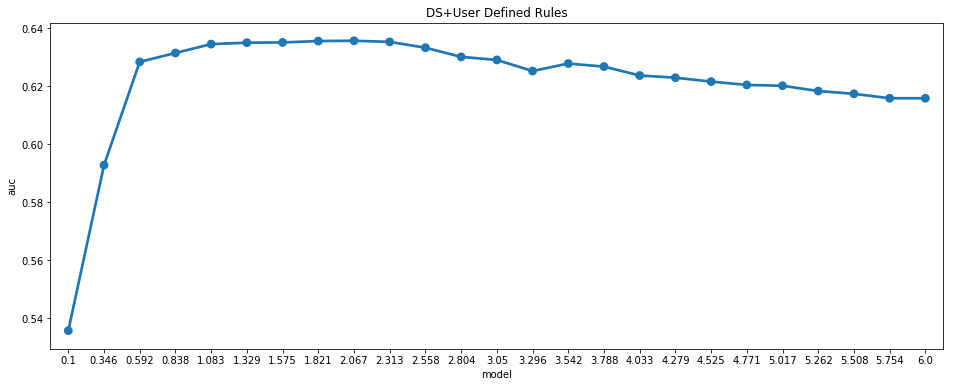

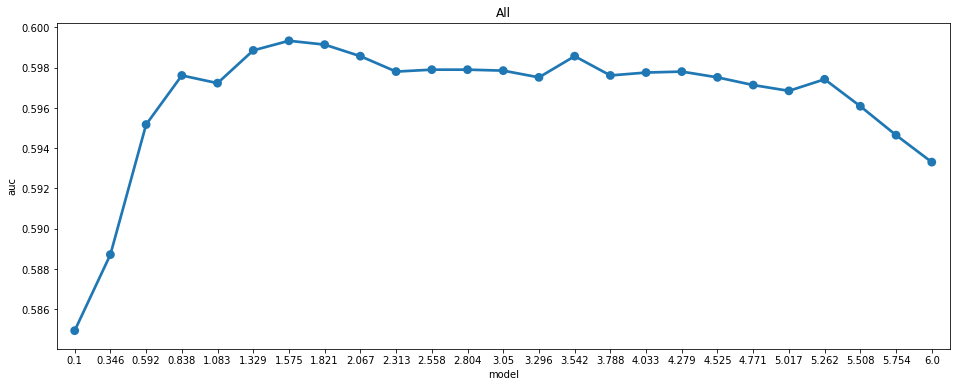

In [16]:
model_grid_aucs = {}
for model in model_grid_search:
    model_grid_aucs[model] = plot_curve(model_grid_search[model], candidate_dfs['dev'].curated_dsh, 
                               figsize=(16,6), model_type='scatterplot', plot_title=model, metric="ROC", font_size=10)

In [17]:
model_grid_auc_dfs = {}
for model in model_grid_aucs:
    model_grid_auc_dfs[model] = (
        get_auc_significant_stats(candidate_dfs['dev'], model_grid_aucs[model])
        .sort_values('auroc', ascending=False)
    )
    print(model)
    print(model_grid_auc_dfs[model].head(5))
    print()

mu: 5224.500000, sigma: 428.635335
Distant Supervision (DS)
          auroc       u       z_u   p_value
1.083  0.555986  5809.5  1.364796  0.086159
1.329  0.555986  5809.5  1.364796  0.086159
0.592  0.555412  5803.5  1.350799  0.088380
1.575  0.555221  5801.5  1.346133  0.089130
1.821  0.555221  5801.5  1.346133  0.089130

mu: 5224.500000, sigma: 428.635335
DS+User Defined Rules
          auroc       u       z_u   p_value
2.067  0.635707  6642.5  3.308173  0.000470
1.821  0.635611  6641.5  3.305840  0.000473
2.313  0.635324  6638.5  3.298841  0.000485
1.575  0.635133  6636.5  3.294175  0.000494
1.329  0.635037  6635.5  3.291842  0.000498

mu: 5224.500000, sigma: 428.635335
All
          auroc       u       z_u   p_value
1.575  0.599340  6262.5  2.421639  0.007725
1.821  0.599148  6260.5  2.416973  0.007825
1.329  0.598861  6257.5  2.409974  0.007977
3.542  0.598574  6254.5  2.402975  0.008131
2.067  0.598574  6254.5  2.402975  0.008131



# Final Evaluation on Held out Hand Labeled Test Data

In [19]:
dev_model_df = pd.DataFrame()
for best_model, model_data, model_label in zip([1.083, 2.067, 1.575], validation_data, model_labels):
    label_model = LabelModel(k=2, seed=100)
    label_model.train_model(model_data[0] , n_epochs=1000, verbose=False, lr=0.01, l2=best_model)
    dev_model_df[model_label] = label_model.predict_proba(model_data[1])[:,0]

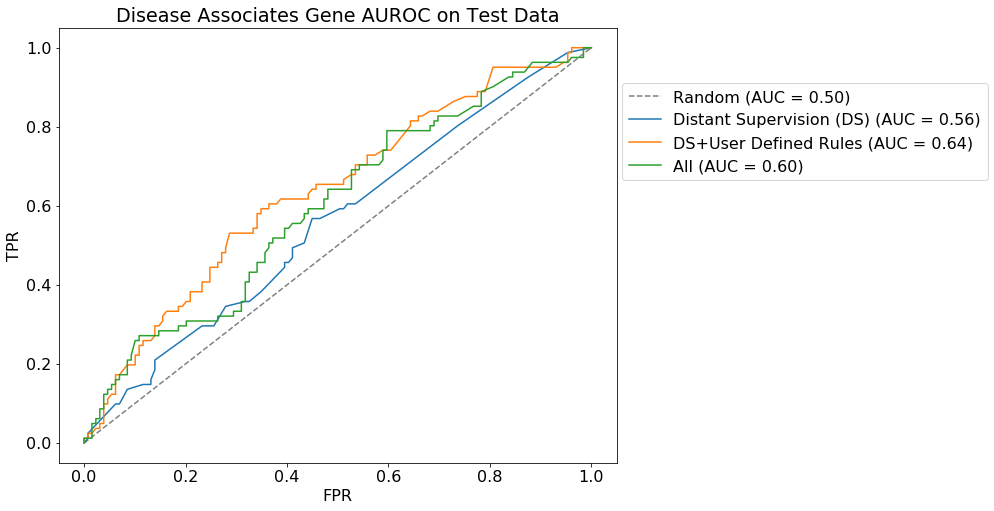

In [34]:
_ = plot_curve(
    dev_model_df, 
    candidate_dfs['dev'].curated_dsh,
    model_type='curve', figsize=(10,8), 
    plot_title="Disease Associates Gene AUROC on Test Data", font_size=16
)

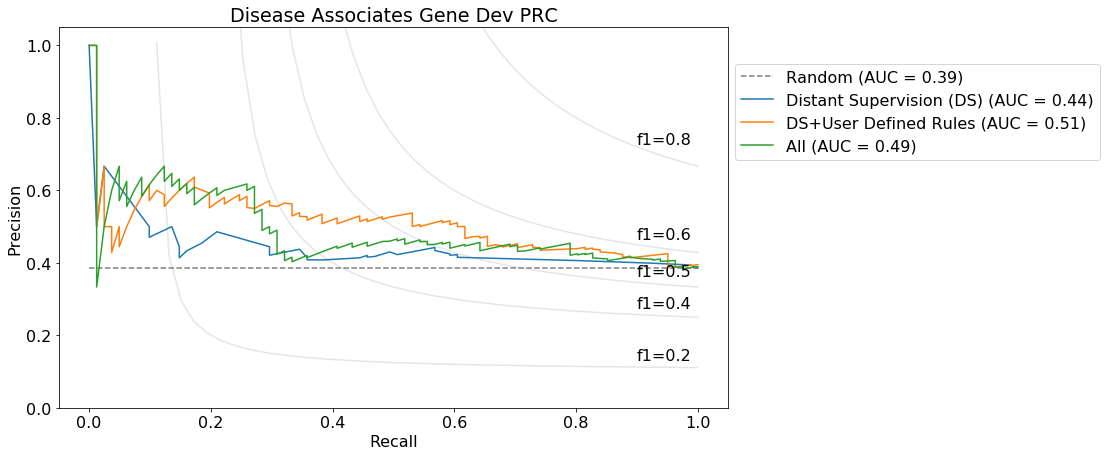

In [36]:
_ = plot_curve(
    dev_model_df, 
    candidate_dfs['dev'].curated_dsh,
    model_type='curve', figsize=(12,7), 
    plot_title="Disease Associates Gene Dev PRC",
    metric='PR', font_size=16
)

In [22]:
label_model = LabelModel(k=2, seed=100)
label_model.train_model(validation_data[1][0], n_epochs=1000, verbose=False, lr=0.01, l2=2.067)
dev_predictions = convert_labels(label_model.predict(validation_data[1][1]), 'categorical', 'onezero')
dev_marginals = label_model.predict_proba(validation_data[1][1])[:,0]

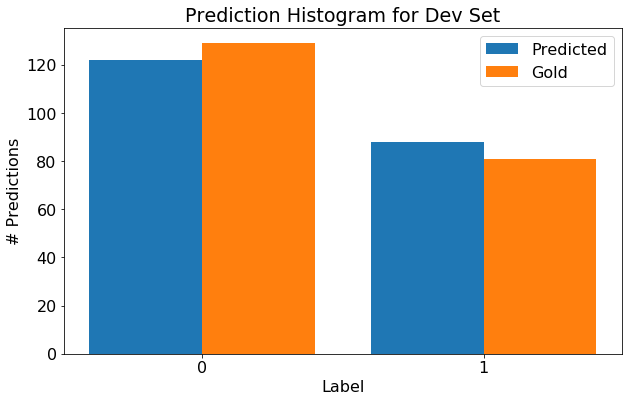

In [23]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,6))
plot_predictions_histogram(
    dev_predictions,
    candidate_dfs['dev'].curated_dsh.astype(int).values,
    title="Prediction Histogram for Dev Set"
)

In [24]:
confusion_matrix(
    convert_labels(candidate_dfs['dev'].curated_dsh.values, 'onezero', 'categorical'),
    convert_labels(dev_predictions, 'onezero', 'categorical')
)

        y=1    y=2   
 l=1    44     37    
 l=2    44     85    


array([[44, 37],
       [44, 85]])

Printed above are the best performing models from the conditinally independent model and the dependency aware model. These reults support the hypothesis that modeling depenency structure improves performance compared to the conditionally indepent assumption. Now that the best parameters are found the next step is to begin training the discriminator model to make the actual classification of sentneces.